## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de ciencia de datos<center>
# <center>Proyecto final<center>
## <center>Transformer para análisis de sentimientos en textos en español<center>

tomado y modificado de:
- https://keras.io/examples/nlp/text_classification_with_transformer/
- https://www.tensorflow.org/tutorials/text/transformer

In [75]:
CurrentPath='/content/drive/MyDrive/Colab Notebooks/ProyectoCiencia/Sentiment/Spanish'

In [76]:
#librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


positional_encoding

In [77]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [78]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


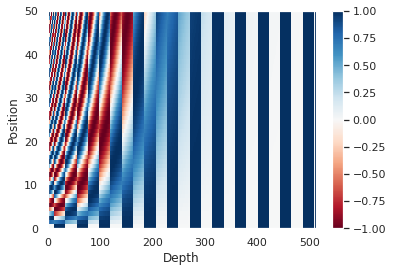

In [79]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Implement multi head self attention as a Keras layer

In [80]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

Implement a Transformer block (Encoder) as a layer

In [81]:
#Encoder x 1
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) #multi-head
        attn_output = self.dropout1(attn_output, training=training) #dropout
        out1 = self.layernorm1(inputs + attn_output) #add & norm
        ffn_output = self.ffn(out1) #feed forward
        ffn_output = self.dropout2(ffn_output, training=training) #dropout
        return self.layernorm2(out1 + ffn_output) #add & norm

Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).

In [82]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, rate=0.1):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = positional_encoding(maxlen, 
                                            embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        seq_len = tf.shape(x)[-1]

        # adding embedding and position encoding.
        x = self.token_emb(x) #imput embedding
        x *= tf.math.sqrt(tf.cast(embed_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        return x 

Dataset

In [83]:
#lee los datos
df=pd.read_csv(CurrentPath+'/train.csv',index_col=0)
df.head()

,tweets,polarity
0,@FridaCoral ven a chetu mejor,NEU
1,quiero y necesito verte yaaaa,P
2,Danniel es como mi amor frustrado,N
3,Solo a los fav responde celosa mil @belindapop...,N
4,@belindapop #AskBeli ¿Porque siempre respondes...,NEU


In [84]:
TEXTS=df.tweets.values
labels=df.polarity.values

pre proceso:
- minusculas
- quita acentos, duplicados
- reemplaza: #, numeros, emojis, url, @

In [85]:
!pip install microtc

In [86]:
from microtc.textmodel import TextModel

def prepTweet(palabras):
  temp=[]
  link=False
  link1=0
  for palabra in palabras:
    if 'htps' not in palabra and link==False:
      temp.append(palabra)
      temp.append(" ")
    else:
      link=True
      if link1==0:
        palabra='url'
        temp.append(palabra)
        temp.append(" ")
      link1+=1
  return "".join(temp)

tm = TextModel(hashtag_option='group')

In [87]:
Corpus_pros=[]
for tweet in TEXTS: #preprocesa los tweets, quita acentos, pone minusculas, quita emojis, cambia links por el string Url
  palabras=tm.tokenize(tweet) 
  tweet_pross=prepTweet(palabras)
  Corpus_pros.append(tweet_pross)

In [88]:
Corpus_pros[3]

'solo a los fav responde celosa mil _usr _htag '

In [89]:
TEXTS_train, TEXTS_test, labels_train, labels_test = train_test_split(Corpus_pros, labels, test_size = .2, stratify=labels, random_state=42) #conjunto de prueba y entrenamiento

Preparación de las secuencias

In [90]:
def MaxlenIncorp(corp):
  maxlen=-1  #obtiene el tamaño maximo de palabras
  if maxlen==-1:
    for doc in corp:
        tokens=nltk.word_tokenize(doc)
        if(maxlen<len(tokens)):
            maxlen=len(tokens)
    print(maxlen)

MaxlenIncorp(TEXTS_train)

35


In [91]:
vocab_size = 40000  # Only consider the top vocab_size words
maxlen = 35  # Only consider the first maxlen words of each movie review

tokenizer=Tokenizer(nb_words=vocab_size)
tokenizer.fit_on_texts(TEXTS_train)
sequencies=tokenizer.texts_to_sequences(TEXTS_train)
X_train=pad_sequences(sequencies,maxlen=maxlen)

sequencies=tokenizer.texts_to_sequences(TEXTS_test)
X_test=pad_sequences(sequencies,maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

y_train=np.array(labels_train)
y_test=np.array(labels_test)
print(y_train.shape)
print(y_test.shape)

y_train=np.reshape(y_train,(-1, 1))
enc_train=OneHotEncoder().fit(y_train)
y_train = enc_train.transform(y_train).toarray()
print(y_train.shape)

y_test=np.reshape(y_test,(-1, 1))
y_test = enc_train.transform(y_test).toarray()
print(y_test.shape)

(3103, 35)
(776, 35)
(3103,)
(776,)
(3103, 3)
(776, 3)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Create classifier model using transformer layer

In [92]:
embed_dim = 512  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim,.45)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim,.4)
x = transformer_block1(x)


x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation="relu")(x)
#x=layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [93]:
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 35)]              0         
_________________________________________________________________
token_and_position_embedding (None, 35, 512)           20480000  
_________________________________________________________________
transformer_block_8 (Transfo (None, 35, 512)           1069584   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 512)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                8208      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)              

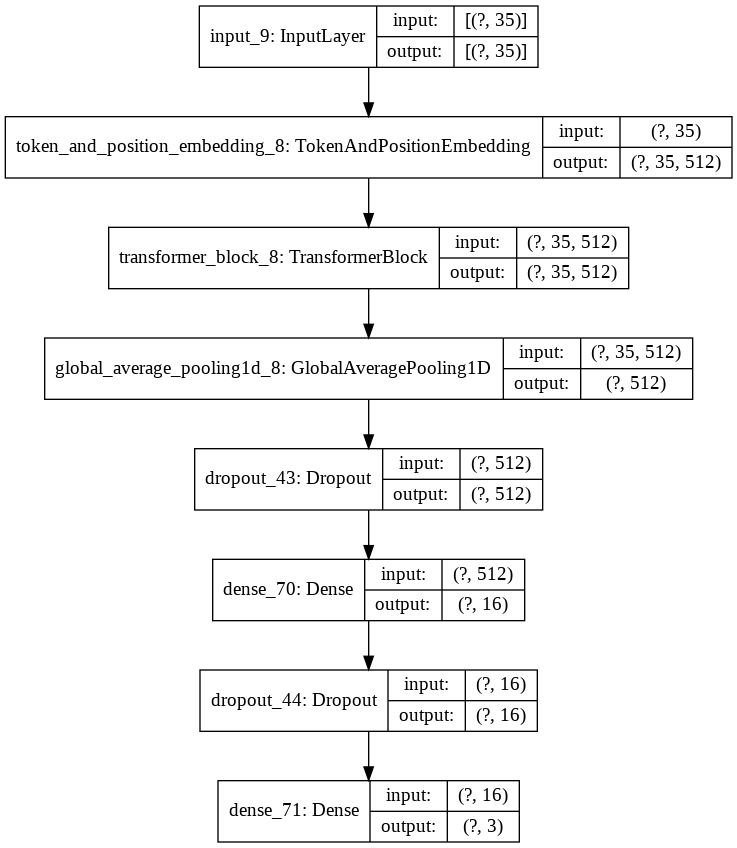

In [94]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='Taller03_1.png',show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Taller03_1.png')

Train and Evaluate

In [95]:
from tensorflow.keras import optimizers

In [100]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss="categorical_crossentropy", metrics=["acc"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test)
)

Epoch 1/2
97/97 [==============================] - 11s 111ms/step - loss: 0.7514 - acc: 0.6445 - val_loss: 0.9533 - val_acc: 0.6160
Epoch 2/2
97/97 [==============================] - 11s 109ms/step - loss: 0.7352 - acc: 0.6461 - val_loss: 0.9617 - val_acc: 0.6237


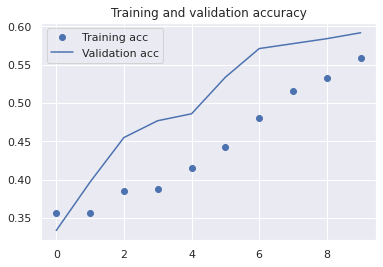

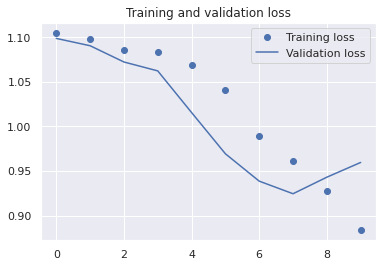

In [97]:


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [101]:
from sklearn.metrics import classification_report, accuracy_score,  confusion_matrix
y_test_pred=model.predict(X_test)
y_test_pred=enc_train.inverse_transform(y_test_pred)
y_test=enc_train.inverse_transform(y_test)

score=accuracy_score(y_test, y_test_pred)
print('test',score)

test 0.6237113402061856


In [102]:

print(classification_report(labels_test, y_test_pred))

              precision    recall  f1-score   support

           N       0.66      0.71      0.68       258
         NEU       0.53      0.47      0.50       259
           P       0.67      0.70      0.68       259

    accuracy                           0.62       776
   macro avg       0.62      0.62      0.62       776
weighted avg       0.62      0.62      0.62       776



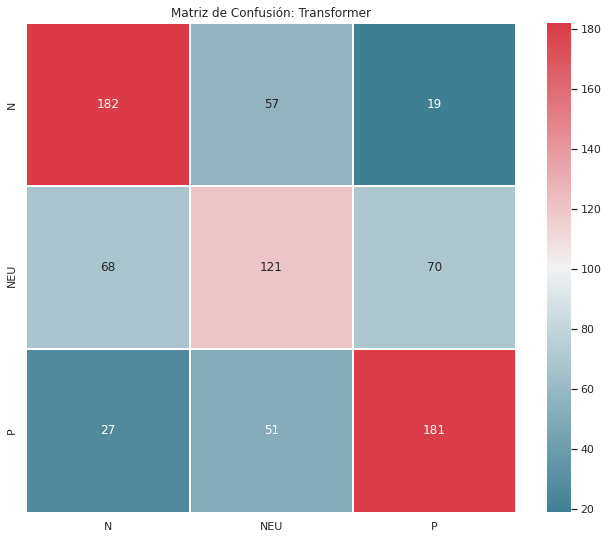

In [103]:
import seaborn as sns

# matriz de confusion
C = confusion_matrix(y_test, y_test_pred)
df_c=pd.DataFrame(C)
df_c.columns=np.unique(y_test).tolist()
df_c.index=np.unique(y_test).tolist()
f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(df_c, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión: Transformer')
plt.show()

In [74]:
del model